In [16]:
from pymongo import MongoClient
import pandas as pd
from collections import Counter

# Experiment 1

In [17]:
def get_statuses_per_parser():
    with MongoClient() as mongo:
        db = mongo['master']
        return db['metrics'].aggregate([
            {
                '$group': {
                    '_id': '$parser',
                    'statuses': {
                        '$push': '$status'
                    }
                }
            }
        ])

Text(0, 0.5, 'number of files')

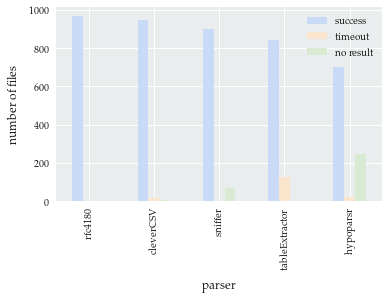

In [18]:
axis = pd.DataFrame([
    {
        'parser': statuses_per_parser['_id'],
        **dict(sum((Counter({('no result' if status == 'error' else status): 1}) for status in statuses_per_parser['statuses']), Counter()))
    }
    for statuses_per_parser in get_statuses_per_parser()
]).sort_values(by=['success'], ascending=[False]).plot(kind='bar', x='parser')
axis.set_ylabel('number of files')

Note: Split bars by file type (simple, complex_single, complex_multi)

# Experiment 2 - not meaningful

In [19]:
def get_success_count_metrics():
    with MongoClient() as mongo:
        db = mongo['master']
        return db['metrics'].aggregate([
            {
                '$group': {
                    '_id': '$fileId',
                    'totalSuccessCount': {
                        '$sum': {
                            '$cond': [
                                {'$eq': ['$status', 'success']},
                                1,
                                0
                            ]
                        }    
                    },
                    'tableExtractorSuccessCount': {
                        '$sum': {
                            '$cond': [
                                { '$and': [{'$eq': ['$status', 'success']}, {'$eq': ['$parser', 'tableExtractor']}]},
                                1,
                                0
                            ]
                        }            
                    },
                    'hypoparsrSuccessCount': {
                        '$sum': {
                            '$cond': [
                                { '$and': [{'$eq': ['$status', 'success']}, {'$eq': ['$parser', 'hypoparsr']}]},
                                1,
                                0
                            ]
                        }            
                    },
                    'cleverCSVSuccessCount': {
                        '$sum': {
                            '$cond': [
                                { '$and': [{'$eq': ['$status', 'success']}, {'$eq': ['$parser', 'cleverCSV']}]},
                                1,
                                0
                            ]
                        }            
                    },
                    'snifferSuccessCount': {
                        '$sum': {
                            '$cond': [
                                { '$and': [{'$eq': ['$status', 'success']}, {'$eq': ['$parser', 'sniffer']}]},
                                1,
                                0
                            ]
                        }            
                    }
                }
            },{
                '$group': {
                    '_id': '$totalSuccessCount',
                    'total': {'$sum': 1} ,
                    'tableExtractorSuccessFileCount': {'$sum': '$tableExtractorSuccessCount'},
                    'hypoparsrSuccessFileCount': {'$sum': '$hypoparsrSuccessCount'},
                    'cleverCSVSuccessFileCount': {'$sum': '$cleverCSVSuccessCount'},
                    'snifferSuccessFileCount': {'$sum': '$snifferSuccessCount'} 
                }    
            }
        ])

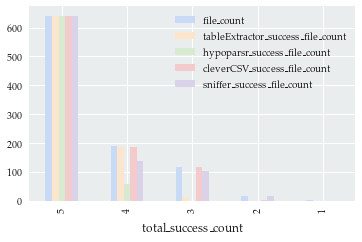

In [20]:
pd.DataFrame([
    {
        'total\_success\_count': file_count_per_success_count['_id'],
        'file\_count': file_count_per_success_count['total'],
        'tableExtractor\_success\_file\_count': file_count_per_success_count['tableExtractorSuccessFileCount'],
        'hypoparsr\_success\_file\_count': file_count_per_success_count['hypoparsrSuccessFileCount'],
        'cleverCSV\_success\_file\_count': file_count_per_success_count['cleverCSVSuccessFileCount'],
        'sniffer\_success\_file\_count': file_count_per_success_count['snifferSuccessFileCount'],
    }
    for file_count_per_success_count in get_success_count_metrics()
]).sort_values(by=['total\_success\_count'], ascending=[False]).plot(kind='bar', x='total\_success\_count')